In [ ]:
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

In [ ]:
def final_fun_1(df):


  #DROPPING FLOOR COUNT AS IT CONTAINS MORE THAN 80% MISSING VALUES

  df.drop('floor_count',axis=1,inplace=True)
  df.reset_index(inplace=True)

  
  df['timestamp']=pd.to_datetime(df['timestamp'])
  df['day']=df['timestamp'].dt.day
  df['month']=df['timestamp'].dt.month

  #FUNCTION TO REDUCE THE MEMORY USAGE
  def reduce_mem_usage(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    #if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


  df_red=reduce_mem_usage(df)

  del df


  df_red[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']]=df_red[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']].astype(np.float32)


  #IMPUTING MISSING VALUES

  cc_fill=df_red.groupby(['site_id','day','month'])['cloud_coverage'].median().reset_index()
  cc_fill.rename(columns={'cloud_coverage':'cc_filler'},inplace=True)
  cc_fill['cc_filler'].fillna(method='ffill',inplace=True)
  df_red=df_red.merge(cc_fill,how='left',on=['site_id','day','month'])
  df_red['cloud_coverage'].fillna(df_red['cc_filler'],inplace=True)
  df_red.drop(labels=['cc_filler'],axis=1,inplace=True)


  wd_fill=df_red.groupby(['site_id','day','month'])['wind_direction'].median().reset_index()
  wd_fill.rename(columns={'wind_direction':'wind_direction_filler'},inplace=True)
  df_red=df_red.merge(wd_fill,how='left',on=['site_id','day','month'])
  df_red['wind_direction'].fillna(df_red['wind_direction_filler'],inplace=True)
  df_red.drop(labels=['wind_direction_filler'],axis=1,inplace=True)


  ws_fill=df_red.groupby(['site_id','day','month'])['wind_speed'].median().reset_index()
  ws_fill.rename(columns={'wind_speed':'wind_speed_filler'},inplace=True)
  df_red=df_red.merge(ws_fill,how='left',on=['site_id','day','month'])
  df_red['wind_speed'].fillna(df_red['wind_speed_filler'],inplace=True)
  df_red.drop(labels=['wind_speed_filler'],axis=1,inplace=True)

  slp_fill=df_red.groupby(['site_id','day','month'])['sea_level_pressure'].median().reset_index()
  slp_fill.rename(columns={'sea_level_pressure':'slp_filler'},inplace=True)
  slp_fill.fillna(method='ffill',inplace=True)
  df_red=df_red.merge(slp_fill,how='left',on=['site_id','day','month'])
  df_red['sea_level_pressure'].fillna(df_red['slp_filler'],inplace=True)
  df_red.drop(labels=['slp_filler'],axis=1,inplace=True)

  pd_fill=df_red.groupby(['site_id','day','month'])['precip_depth_1_hr'].median().reset_index()
  pd_fill.rename(columns={'precip_depth_1_hr':'pd_filler'},inplace=True)
  pd_fill['pd_filler'].fillna(method='ffill',inplace=True)
  df_red=df_red.merge(pd_fill,how='left',on=['site_id','day','month'])
  df_red['precip_depth_1_hr'].fillna(df_red['pd_filler'],inplace=True)
  df_red.drop(labels=['pd_filler'],axis=1,inplace=True)

  yb_fill=df_red.groupby(['site_id','day','month'])['year_built'].median().reset_index()
  yb_fill.rename(columns={'year_built':'yb_filler'},inplace=True)
  yb_fill['yb_filler'].fillna(method='ffill',inplace=True)
  df_red=df_red.merge(yb_fill,how='left',on=['site_id','day','month'])
  df_red['year_built'].fillna(df_red['yb_filler'],inplace=True)
  df_red.drop(labels=['yb_filler'],axis=1,inplace=True)


  df_red['air_temperature']=df_red['air_temperature'].interpolate(method='linear')
  df_red['dew_temperature']=df_red['dew_temperature'].interpolate(method='linear')


  
  #ALIGNING TIMESTAMP
  df_train_site_0=df_red[df_red['site_id']==0]
  df_train_site_0.reset_index(inplace=True)
  df_train_site_0['timestamp_aligned']=df_train_site_0['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_0[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_0.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_0['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_0['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_0['air_temperature_aligned']=df_train_site_0['air_temperature_aligned'].interpolate()
  df_train_site_0.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_0.drop(['level_0','index'],axis=1,inplace=True)

  df_train_site_1=df_red[df_red['site_id']==1]
  df_train_site_1.reset_index(inplace=True)
  df_train_site_1.drop(['index','level_0'],axis=1,inplace=True)

  df_train_site_2=df_red[df_red['site_id']==2]
  df_train_site_2.reset_index(inplace=True)
  df_train_site_2['timestamp_aligned']=df_train_site_2['timestamp']-timedelta(hours=7,minutes=0)
  df_air_temp_timestamp=df_train_site_2[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_2.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_2['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_2['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_2['air_temperature_aligned']=df_train_site_2['air_temperature_aligned'].interpolate()
  df_train_site_2.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_2.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_3=df_red[df_red['site_id']==3]
  df_train_site_3.reset_index(inplace=True)
  df_train_site_3['timestamp_aligned']=df_train_site_3['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_3[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_3.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_3['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_3['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_3['air_temperature_aligned']=df_train_site_3['air_temperature_aligned'].interpolate()
  df_train_site_3.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_3.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_4=df_red[df_red['site_id']==4]
  df_train_site_4.reset_index(inplace=True)
  df_train_site_4['timestamp_aligned']=df_train_site_4['timestamp']-timedelta(hours=8,minutes=0)
  df_air_temp_timestamp=df_train_site_4[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_4.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_4['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_4['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_4['air_temperature_aligned']=df_train_site_4['air_temperature_aligned'].interpolate()
  df_train_site_4.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_4.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_5=df_red[df_red['site_id']==5]
  df_train_site_5.reset_index(inplace=True)
  df_train_site_5.drop(['index','level_0'],axis=1,inplace=True)


  df_train_site_6=df_red[df_red['site_id']==6]
  df_train_site_6.reset_index(inplace=True)
  df_train_site_6['timestamp_aligned']=df_train_site_6['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_6[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_6.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_6['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_6['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_6['air_temperature_aligned']=df_train_site_6['air_temperature_aligned'].interpolate()
  df_train_site_6.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_6.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_7=df_red[df_red['site_id']==7]
  df_train_site_7.reset_index(inplace=True)
  df_train_site_7['timestamp_aligned']=df_train_site_7['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_7[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_7.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_7['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_7['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_7['air_temperature_aligned']=df_train_site_7['air_temperature_aligned'].interpolate()
  df_train_site_7.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_7.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_8=df_red[df_red['site_id']==8]
  df_train_site_8.reset_index(inplace=True)
  df_train_site_8['timestamp_aligned']=df_train_site_8['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_8[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_8.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_8['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_8['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_8['air_temperature_aligned']=df_train_site_8['air_temperature_aligned'].interpolate()
  df_train_site_8.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_8.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_9=df_red[df_red['site_id']==9]
  df_train_site_9.reset_index(inplace=True)
  df_train_site_9['timestamp_aligned']=df_train_site_9['timestamp']-timedelta(hours=6,minutes=0)
  df_air_temp_timestamp=df_train_site_9[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_9.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_9['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_9['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_9['air_temperature_aligned']=df_train_site_9['air_temperature_aligned'].interpolate()
  df_train_site_9.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_9.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_10=df_red[df_red['site_id']==10]
  df_train_site_10.reset_index(inplace=True)
  df_train_site_10['timestamp_aligned']=df_train_site_10['timestamp']-timedelta(hours=7,minutes=0)
  df_air_temp_timestamp=df_train_site_10[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_10.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_10['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_10['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_10['air_temperature_aligned']=df_train_site_10['air_temperature_aligned'].interpolate()
  df_train_site_10.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_10.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_11=df_red[df_red['site_id']==11]
  df_train_site_11.reset_index(inplace=True)
  df_train_site_11['timestamp_aligned']=df_train_site_11['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_11[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_11.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_11['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_11['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_11['air_temperature_aligned']=df_train_site_11['air_temperature_aligned'].interpolate()
  df_train_site_11.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_11.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_12=df_red[df_red['site_id']==12]
  df_train_site_12.reset_index(inplace=True)
  df_train_site_12.drop(['index','level_0'],axis=1,inplace=True)


  df_train_site_13=df_red[df_red['site_id']==13]
  df_train_site_13.reset_index(inplace=True)
  df_train_site_13['timestamp_aligned']=df_train_site_13['timestamp']-timedelta(hours=6,minutes=0)
  df_air_temp_timestamp=df_train_site_13[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_13.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_13['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_13['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_13['air_temperature_aligned']=df_train_site_13['air_temperature_aligned'].interpolate()
  df_train_site_13.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_13.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_14=df_red[df_red['site_id']==14]
  df_train_site_14.reset_index(inplace=True)
  df_train_site_14['timestamp_aligned']=df_train_site_14['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_14[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_14.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_14['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_14['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_14['air_temperature_aligned']=df_train_site_14['air_temperature_aligned'].interpolate()
  df_train_site_14.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_14.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_15=df_red[df_red['site_id']==15]
  df_train_site_15.reset_index(inplace=True)
  df_train_site_15['timestamp_aligned']=df_train_site_15['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_15[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_15.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_15['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_15['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_15['air_temperature_aligned']=df_train_site_15['air_temperature_aligned'].interpolate()
  df_train_site_15.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_15.drop(['level_0','index'],axis=1,inplace=True)

  #Concatenating the data and making it ready for final predictions
  df_final=pd.concat([df_train_site_0,df_train_site_1,df_train_site_2,df_train_site_3,df_train_site_4,
                                 df_train_site_5,df_train_site_6,df_train_site_7,df_train_site_8,df_train_site_9,
                                 df_train_site_10,df_train_site_11,df_train_site_12,df_train_site_13,df_train_site_14,
                                 df_train_site_15],axis=0)
    
    
  df_final.reset_index(inplace=True)

  df_final.drop(['row_id','index','primary_use','square_feet','year_built','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','day','month'],axis=1,inplace=True)
  df_red.drop('index',axis=1,inplace=True)

  df_final.rename(columns={'air_temperature':'air_temperature_aligned'},inplace=True)
  df_final_red=pd.merge(left=df_red,right=df_final,on=['site_id','timestamp','meter','building_id'])

  del df_final,df_red
  del df_train_site_0,df_train_site_1,df_train_site_2,df_train_site_3,df_train_site_4,df_train_site_5,df_train_site_6,df_train_site_7,df_train_site_8,df_train_site_9,df_train_site_10,df_train_site_11,df_train_site_12,df_train_site_13,df_train_site_14,df_train_site_15

  df_final_red.drop('air_temperature',axis=1,inplace=True)
  df_final_red.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)


  #FEATURE-ENGINEERING
  saturated_vapor_pressure = 6.11 * (10**(7.5*df_final_red['air_temperature']/(237.3+df_final_red['air_temperature'])))
  actual_vapor_pressure = 6.11 * (10**(7.5*df_final_red['dew_temperature']/(237.3+df_final_red['dew_temperature'])))
  df_final_red['relative_humidity']=(actual_vapor_pressure/saturated_vapor_pressure)*100


  df_final_red['is_winter_month']=(df_final_red['month'].isin([12,1,2])).astype(int)
  df_final_red['is_summer_month']=(df_final_red['month'].isin([6,7,8])).astype(int)
  df_final_red['weekday']=df_final_red['timestamp'].dt.weekday

  holidays = ["2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
            "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
            "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
            "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
            "2019-01-01"]

  holiday_datetime=pd.to_datetime(holidays,yearfirst=True)
  df_final_red['is_pub_holiday']=(df_final_red['timestamp'].dt.date.isin(holiday_datetime.date)).astype(int)
  df_final_red['is_weekday']=((~df_final_red['timestamp'].dt.date.isin(holiday_datetime.date))&(df_final_red['weekday'].isin([0,1,2,3,4]))).astype(int)

  z_busy_hours=df_final_red.set_index(['timestamp']).between_time('06:00:00','18:00:00').reset_index()
  z_busy_hours_timestamp=[i for i in z_busy_hours['timestamp']]
  df_final_red['busy_hours']=((~df_final_red['timestamp'].dt.date.isin(holiday_datetime.date))&(df_final_red['timestamp'].isin(z_busy_hours_timestamp))).astype(int)

  df_final_red['hour']=df_final_red['timestamp'].dt.hour

  df_final_reduce=reduce_mem_usage(df_final_red)

  del df_final_red

  df_final_reduce.drop(['timestamp'],axis=1,inplace=True)

  label_encoder=LabelEncoder()
  df_final_reduce['primary_use']=label_encoder.fit_transform(df_final_reduce['primary_use'])

  df_final_reduce_1=reduce_mem_usage(df_final_reduce)

  del df_final_reduce


  #DROPPING FEATURES WHICH ARE NOT IMPORTANT
  df_final_reduce_1.drop(['cloud_coverage','sea_level_pressure','wind_direction','wind_speed',
                      'is_summer_month','is_pub_holiday'],axis=1,inplace=True)
  
  df_final_reduce_1.drop('row_id',axis=1,inplace=True)

  file_2=open('/content/drive/MyDrive/Project Energy Consumption/lgbm_model_2.txt','rb')
  lgbm_model=pickle.load(file_2)

  #Prediction on the test set
  y_test=lgbm_model.predict(df_final_reduce_1)

  y_test=np.expm1(y_test)


  return y_test
  

**Importing the data from kaggle API**

In [ ]:
from google.colab import files
file=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c ashrae-energy-prediction

 83% 73.0M/88.4M [00:00<00:00, 67.9MB/s]
100% 88.4M/88.4M [00:00<00:00, 121MB/s] 
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 44.9MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 177MB/s]
 89% 107M/120M [00:01<00:00, 77.3MB/s] 
100% 120M/120M [00:01<00:00, 108MB/s] 
100% 167M/167M [00:01<00:00, 119MB/s]

  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 167MB/s]


In [ ]:
!unzip /content/test.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                


In [ ]:
!unzip /content/weather_test.csv.zip

Archive:  /content/weather_test.csv.zip
  inflating: weather_test.csv        


**Function for reducing the memory usage**

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

**From here on we will be merging the test data with building data and weather test data so that it can be passed to the final fun 1 so that it can be preocessed and predictions can be made on it.**

In [ ]:
df_test=pd.read_csv('test.csv')

In [ ]:
df_test_red=reduce_mem_usage(df_test,verbose=True)

Mem. usage decreased to 596.49 Mb (53.1% reduction)


In [ ]:
del df_test

In [ ]:
df_weather_test=pd.read_csv('weather_test.csv')

In [ ]:
df_weather_test_red=reduce_mem_usage(df_weather_test,verbose=True)

Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [ ]:
del df_weather_test

In [ ]:
df_building=pd.read_csv('building_metadata.csv')

In [ ]:
df_building_red=reduce_mem_usage(df_building,verbose=True)

Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [ ]:
df_test_build=pd.merge(df_test_red,df_building_red,how='left',on=['building_id'])

In [ ]:
df_test_merge=pd.merge(df_test_build,df_weather_test_red,how='left',on=['site_id','timestamp'])

**Passing a single row to the final fun 1 which will return the predictions on the test set**

In [ ]:
df_test_row=df_test_merge.head(1)

In [ ]:
prediction=final_fun_1(df_test_row)#Passing a single row value to the function which will return the prediction

In [ ]:
prediction

array([154.26641186])

**Constructing my 2nd function which will take train dataframe and corresponding target variable which will return the RMSLE Score(metric-score)**

In [ ]:
def final_fun_2(df,y):

  #FILTERING OUTLIERS
  

  df.drop(index=df[(df['building_id']<=104) & (df['meter']==0) & (df['timestamp']<'2016-05-21')].index,inplace=True)
  df.drop(index=df[(df['building_id']==45) & (df['meter']==0) & (df['timestamp']<'2016-06')].index,inplace=True)
  df.drop(index=df[(df['building_id']==53) & (df['meter']==0)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==1099) & (df['meter']==2)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==1250) & (df['meter']==2)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==1227) & (df['meter']==0)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==1314) & (df['meter']==0)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==1281) & (df['meter']==0)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==279) & (df['meter']==3)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==263) & (df['meter']==3)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==287) & (df['meter']==3)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==1018) & (df['meter']==1)].index,inplace=True)#Removing Anamolous Building
  df.drop(index=df[(df['building_id']==1022) & (df['meter']==1)].index,inplace=True)#Removing Anamolous Building


  df[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']]=df[['year_built','air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']].astype(np.float32)

  df.drop('floor_count',axis=1,inplace=True)
  df.reset_index(inplace=True)

  df['day']=df['timestamp'].dt.day
  df['month']=df['timestamp'].dt.month


  #Imputing missing values
  cc_fill=df.groupby(['site_id','day','month'])['cloud_coverage'].median().reset_index()
  cc_fill.rename(columns={'cloud_coverage':'cc_filler'},inplace=True)
  cc_fill['cc_filler'].fillna(method='ffill',inplace=True)
  df=df.merge(cc_fill,how='left',on=['site_id','day','month'])
  df['cloud_coverage'].fillna(df['cc_filler'],inplace=True)
  df.drop(labels=['cc_filler'],axis=1,inplace=True)


  wd_fill=df.groupby(['site_id','day','month'])['wind_direction'].median().reset_index()
  wd_fill.rename(columns={'wind_direction':'wind_direction_filler'},inplace=True)
  df=df.merge(wd_fill,how='left',on=['site_id','day','month'])
  df['wind_direction'].fillna(df['wind_direction_filler'],inplace=True)
  df.drop(labels=['wind_direction_filler'],axis=1,inplace=True)


  ws_fill=df.groupby(['site_id','day','month'])['wind_speed'].median().reset_index()
  ws_fill.rename(columns={'wind_speed':'wind_speed_filler'},inplace=True)
  df=df.merge(ws_fill,how='left',on=['site_id','day','month'])
  df['wind_speed'].fillna(df['wind_speed_filler'],inplace=True)
  df.drop(labels=['wind_speed_filler'],axis=1,inplace=True)

  slp_fill=df.groupby(['site_id','day','month'])['sea_level_pressure'].median().reset_index()
  slp_fill.rename(columns={'sea_level_pressure':'slp_filler'},inplace=True)
  slp_fill.fillna(method='ffill',inplace=True)
  df=df.merge(slp_fill,how='left',on=['site_id','day','month'])
  df['sea_level_pressure'].fillna(df['slp_filler'],inplace=True)
  df.drop(labels=['slp_filler'],axis=1,inplace=True)

  pd_fill=df.groupby(['site_id','day','month'])['precip_depth_1_hr'].median().reset_index()
  pd_fill.rename(columns={'precip_depth_1_hr':'pd_filler'},inplace=True)
  pd_fill['pd_filler'].fillna(method='ffill',inplace=True)
  df=df.merge(pd_fill,how='left',on=['site_id','day','month'])
  df['precip_depth_1_hr'].fillna(df['pd_filler'],inplace=True)
  df.drop(labels=['pd_filler'],axis=1,inplace=True)

  yb_fill=df.groupby(['site_id','day','month'])['year_built'].median().reset_index()
  yb_fill.rename(columns={'year_built':'yb_filler'},inplace=True)
  yb_fill['yb_filler'].fillna(method='ffill',inplace=True)
  df=df.merge(yb_fill,how='left',on=['site_id','day','month'])
  df['year_built'].fillna(df['yb_filler'],inplace=True)
  df.drop(labels=['yb_filler'],axis=1,inplace=True)


  df['air_temperature']=df['air_temperature'].interpolate(method='linear')
  df['dew_temperature']=df['dew_temperature'].interpolate(method='linear')


  #Function for reducing the memory usage
  def reduce_mem_usage(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    #if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

  df_red=reduce_mem_usage(df)

  #Aligning Timestamp

  df_train_site_0=df_red[df_red['site_id']==0]
  df_train_site_0.reset_index(inplace=True)
  df_train_site_0['timestamp_aligned']=df_train_site_0['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_0[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_0.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_0['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_0['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_0['air_temperature_aligned']=df_train_site_0['air_temperature_aligned'].interpolate()
  df_train_site_0.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_0.drop(['level_0','index'],axis=1,inplace=True)

  df_train_site_1=df_red[df_red['site_id']==1]
  df_train_site_1.reset_index(inplace=True)
  df_train_site_1.drop(['index','level_0'],axis=1,inplace=True)

  df_train_site_2=df_red[df_red['site_id']==2]
  df_train_site_2.reset_index(inplace=True)
  df_train_site_2['timestamp_aligned']=df_train_site_2['timestamp']-timedelta(hours=7,minutes=0)
  df_air_temp_timestamp=df_train_site_2[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_2.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_2['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_2['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_2['air_temperature_aligned']=df_train_site_2['air_temperature_aligned'].interpolate()
  df_train_site_2.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_2.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_3=df_red[df_red['site_id']==3]
  df_train_site_3.reset_index(inplace=True)
  df_train_site_3['timestamp_aligned']=df_train_site_3['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_3[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_3.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_3['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_3['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_3['air_temperature_aligned']=df_train_site_3['air_temperature_aligned'].interpolate()
  df_train_site_3.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_3.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_4=df_red[df_red['site_id']==4]
  df_train_site_4.reset_index(inplace=True)
  df_train_site_4['timestamp_aligned']=df_train_site_4['timestamp']-timedelta(hours=8,minutes=0)
  df_air_temp_timestamp=df_train_site_4[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_4.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_4['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_4['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_4['air_temperature_aligned']=df_train_site_4['air_temperature_aligned'].interpolate()
  df_train_site_4.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_4.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_5=df_red[df_red['site_id']==5]
  df_train_site_5.reset_index(inplace=True)
  df_train_site_5.drop(['index','level_0'],axis=1,inplace=True)


  df_train_site_6=df_red[df_red['site_id']==6]
  df_train_site_6.reset_index(inplace=True)
  df_train_site_6['timestamp_aligned']=df_train_site_6['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_6[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_6.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_6['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_6['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_6['air_temperature_aligned']=df_train_site_6['air_temperature_aligned'].interpolate()
  df_train_site_6.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_6.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_7=df_red[df_red['site_id']==7]
  df_train_site_7.reset_index(inplace=True)
  df_train_site_7['timestamp_aligned']=df_train_site_7['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_7[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_7.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_7['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_7['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_7['air_temperature_aligned']=df_train_site_7['air_temperature_aligned'].interpolate()
  df_train_site_7.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_7.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_8=df_red[df_red['site_id']==8]
  df_train_site_8.reset_index(inplace=True)
  df_train_site_8['timestamp_aligned']=df_train_site_8['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_8[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_8.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_8['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_8['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_8['air_temperature_aligned']=df_train_site_8['air_temperature_aligned'].interpolate()
  df_train_site_8.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_8.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_9=df_red[df_red['site_id']==9]
  df_train_site_9.reset_index(inplace=True)
  df_train_site_9['timestamp_aligned']=df_train_site_9['timestamp']-timedelta(hours=6,minutes=0)
  df_air_temp_timestamp=df_train_site_9[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_9.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_9['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_9['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_9['air_temperature_aligned']=df_train_site_9['air_temperature_aligned'].interpolate()
  df_train_site_9.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_9.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_10=df_red[df_red['site_id']==10]
  df_train_site_10.reset_index(inplace=True)
  df_train_site_10['timestamp_aligned']=df_train_site_10['timestamp']-timedelta(hours=7,minutes=0)
  df_air_temp_timestamp=df_train_site_10[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_10.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_10['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_10['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_10['air_temperature_aligned']=df_train_site_10['air_temperature_aligned'].interpolate()
  df_train_site_10.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_10.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_11=df_red[df_red['site_id']==11]
  df_train_site_11.reset_index(inplace=True)
  df_train_site_11['timestamp_aligned']=df_train_site_11['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_11[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_11.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_11['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_11['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_11['air_temperature_aligned']=df_train_site_11['air_temperature_aligned'].interpolate()
  df_train_site_11.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_11.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_12=df_red[df_red['site_id']==12]
  df_train_site_12.reset_index(inplace=True)
  df_train_site_12.drop(['index','level_0'],axis=1,inplace=True)


  df_train_site_13=df_red[df_red['site_id']==13]
  df_train_site_13.reset_index(inplace=True)
  df_train_site_13['timestamp_aligned']=df_train_site_13['timestamp']-timedelta(hours=6,minutes=0)
  df_air_temp_timestamp=df_train_site_13[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_13.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_13['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_13['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_13['air_temperature_aligned']=df_train_site_13['air_temperature_aligned'].interpolate()
  df_train_site_13.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_13.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_14=df_red[df_red['site_id']==14]
  df_train_site_14.reset_index(inplace=True)
  df_train_site_14['timestamp_aligned']=df_train_site_14['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_14[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_14.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_14['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_14['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_14['air_temperature_aligned']=df_train_site_14['air_temperature_aligned'].interpolate()
  df_train_site_14.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_14.drop(['level_0','index'],axis=1,inplace=True)


  df_train_site_15=df_red[df_red['site_id']==15]
  df_train_site_15.reset_index(inplace=True)
  df_train_site_15['timestamp_aligned']=df_train_site_15['timestamp']-timedelta(hours=5,minutes=0)
  df_air_temp_timestamp=df_train_site_15[['timestamp_aligned','building_id','meter','air_temperature']].copy()
  df_air_temp_timestamp.rename(columns={'timestamp_aligned':'timestamp'},inplace=True)
  df_train_site_15.drop(['air_temperature','timestamp_aligned'],axis=1,inplace=True)
  df_train_site_15['air_temperature_aligned']=df_air_temp_timestamp[df_air_temp_timestamp['timestamp'].isin(df_train_site_15['timestamp'])].reset_index(drop=True)['air_temperature']
  df_train_site_15['air_temperature_aligned']=df_train_site_15['air_temperature_aligned'].interpolate()
  df_train_site_15.rename(columns={'air_temperature_aligned':'air_temperature'},inplace=True)
  df_train_site_15.drop(['level_0','index'],axis=1,inplace=True)

  #Concatenating the aligned dataframe and then sorting it to convert it back to original train set
  df_final=pd.concat([df_train_site_0,df_train_site_1,df_train_site_2,df_train_site_3,df_train_site_4,
                                 df_train_site_5,df_train_site_6,df_train_site_7,df_train_site_8,df_train_site_9,
                                 df_train_site_10,df_train_site_11,df_train_site_12,df_train_site_13,df_train_site_14,
                                 df_train_site_15],axis=0)



  df_final=df_final.sort_values(['timestamp','building_id'])

  #Feature Engineering

  saturated_vapor_pressure = 6.11 * (10**(7.5*df_final['air_temperature']/(237.3+df_final['air_temperature'])))
  actual_vapor_pressure = 6.11 * (10**(7.5*df_final['dew_temperature']/(237.3+df_final['dew_temperature'])))
  df_final['relative_humidity']=(actual_vapor_pressure/saturated_vapor_pressure)*100

  df_final['is_winter_month']=(df_final['month'].isin([12,1,2])).astype(int)
  df_final['is_summer_month']=(df_final['month'].isin([6,7,8])).astype(int)
  df_final['weekday']=df_final['timestamp'].dt.weekday

  holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
            "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-25"]

  holiday_datetime=pd.to_datetime(holidays,yearfirst=True)
  df_final['is_pub_holiday']=(df_final['timestamp'].dt.date.isin(holiday_datetime.date)).astype(int)
  df_final['is_weekday']=((~df_final['timestamp'].dt.date.isin(holiday_datetime.date))&(df_final['weekday'].isin([0,1,2,3,4]))).astype(int)

  z_busy_hours=df_final.set_index(['timestamp']).between_time('06:00:00','18:00:00').reset_index()
  z_busy_hours_timestamp=[i for i in z_busy_hours['timestamp']]
  df_final['busy_hours']=((~df_final['timestamp'].dt.date.isin(holiday_datetime.date))&(df_final['timestamp'].isin(z_busy_hours_timestamp))).astype(int)

  df_final['hour']=df_final['timestamp'].dt.hour

  df_final.reset_index(inplace=True)

  df_final=reduce_mem_usage(df_final)


  del df_train_site_0,df_train_site_1,df_train_site_2,df_train_site_3,df_train_site_4,df_train_site_5,df_train_site_6,df_train_site_7,df_train_site_8,df_train_site_9,df_train_site_10,df_train_site_11,df_train_site_12,df_train_site_13,df_train_site_14,df_train_site_15

  label_encoder=LabelEncoder()
  df_final['primary_use']=label_encoder.fit_transform(df_final['primary_use'])

  df_final=reduce_mem_usage(df_final)

  #Dropping features which are not important

  df_final.drop(['cloud_coverage','sea_level_pressure','wind_direction','wind_speed',
                      'is_summer_month','is_pub_holiday','index','timestamp'],axis=1,inplace=True)
  
  file_2=open('/content/drive/MyDrive/Project Energy Consumption/lgbm_model_2.txt','rb')
  lgbm_model_2=pickle.load(file_2)

  #Predicting on the final train dataset and then finding out the metric score(RMSLE Score)

  y_pred=lgbm_model_2.predict(df_final)
  rmsle_score=np.sqrt(mean_squared_error(y,y_pred))
  

  return rmsle_score








**From here on we will be merging the train data with building data and weather test data so that it can be passed to the final fun 2 so that it can be preocessed and predictions can be made on it.****

In [ ]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
!unzip /content/weather_train.csv.zip

Archive:  /content/weather_train.csv.zip
  inflating: weather_train.csv       


In [ ]:
df_train=pd.read_csv('train.csv')

In [ ]:
df_train_red=reduce_mem_usage(df_train,verbose=True)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [ ]:
df_weather_train=pd.read_csv('weather_train.csv')

In [ ]:
df_weather_train_red=reduce_mem_usage(df_weather_train,verbose=True)

Mem. usage decreased to  3.07 Mb (68.1% reduction)


In [ ]:
df_building=pd.read_csv('building_metadata.csv')

In [ ]:
df_building_red=reduce_mem_usage(df_building,verbose=True)

Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [ ]:
df_train_build=pd.merge(df_train_red,df_building_red,how='left',on=['building_id'])

In [ ]:
df_train_merge=pd.merge(df_train_build,df_weather_train_red,how='left',on=['site_id','timestamp'])

In [ ]:
df_train_merge['timestamp']=pd.to_datetime(df_train_merge['timestamp'])

In [ ]:
y_tr=np.log1p(df_train_merge['meter_reading'])
df_train_merge.drop('meter_reading',axis=1,inplace=True)

In [ ]:
df_train_row=df_train_merge[df_train_merge['meter']==1].head(1)

In [ ]:
y=np.array(y_tr)

In [ ]:
y=y.reshape(-1,1)

**Passing a single row of train set and target variable so that it can return the metric score(RMSLE)**

In [ ]:
metric_score=final_fun_2(df_train_row,y[172])

In [ ]:
metric_score

1.602411423767173

REF-->#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
      #https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling

In [ ]:
#LINK OF MODEL DEPLOYMENT
https://www.youtube.com/watch?v=0oQpzSHKwqw
https://www.youtube.com/watch?v=LiHWJZCGHbE

In [1]:
from IPython.core.display import Image, display

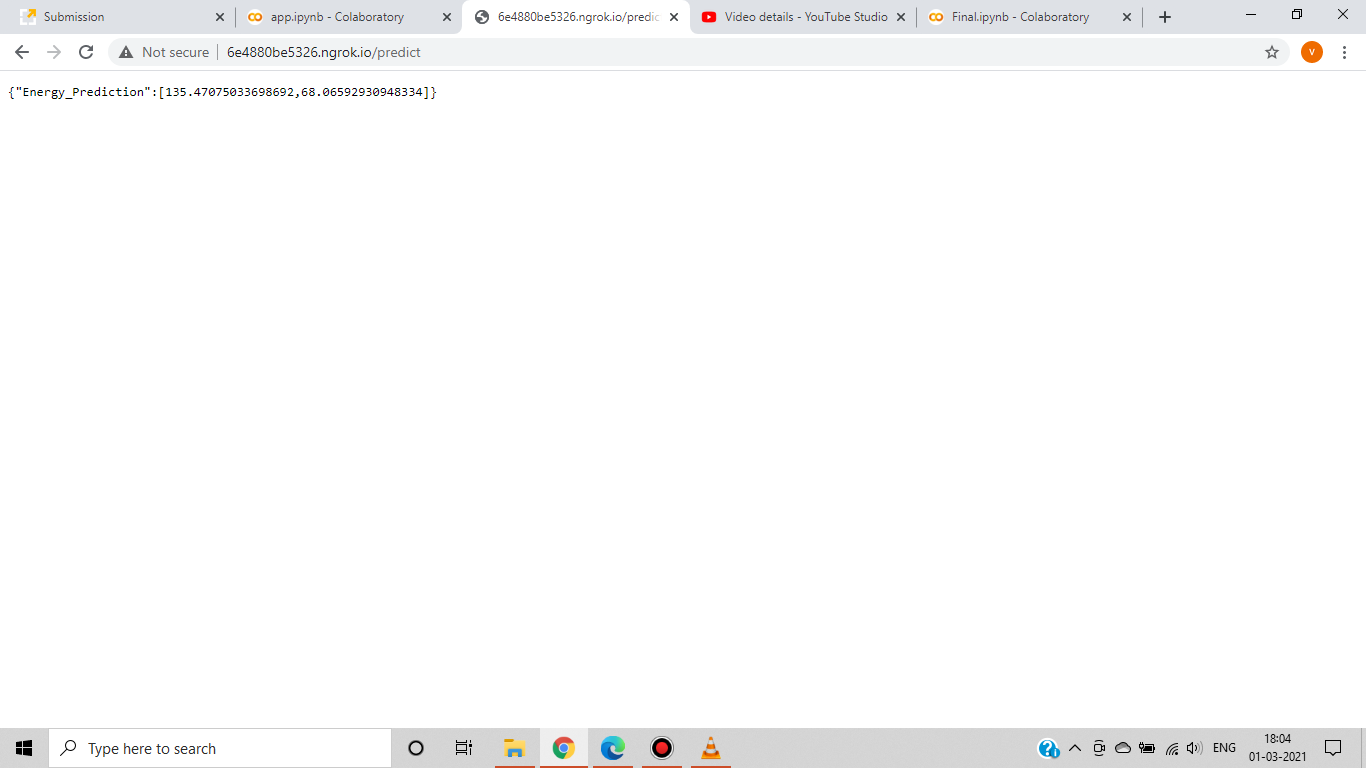

In [8]:
#Screenshots of model making multiple predictions
file='/content/drive/MyDrive/Screenshot (13).png'
display(Image(filename=file))

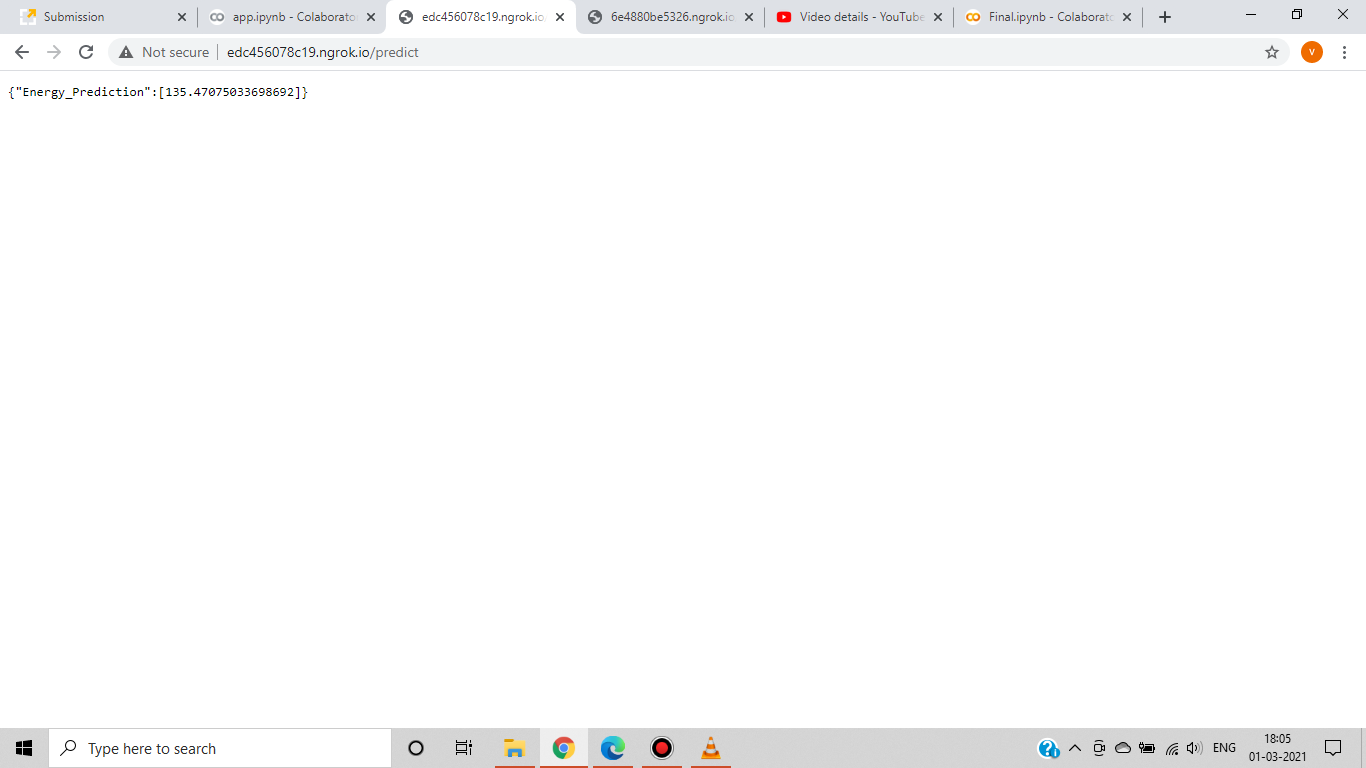

In [9]:
#Screenshot of model making single prediction
file='/content/drive/MyDrive/Screenshot (14).png'
display(Image(filename=file))